In [1]:

import time
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from numba import jit,int8,float32,float64
tqdm.pandas()

from Back_Testing.TradeSim import *
from Strategy.Performance_Evaluation import *
from Data.data_pulling import *
from Strategy.signal_rongbin import *
import matplotlib.pyplot as plt
plt.style.use('seaborn')


In [2]:
ticker_list=['GOOG','YELP','QQQ']

time_slice=('09:40','15:50')
freq='100ms'
init_capital=10**6

opt_params_dict={'CB':{"GOOG":(20,0.005),'YELP':(80,0.0075),'QQQ':(10,0.0025)},
                 
                 
                 }



cb_params_dict=opt_params_dict['CB']

## 1.Load Data

In [3]:
tot_order_book_dict={}
for ticker in ticker_list:
    df=pd.read_csv('./Data/%s_order_book.csv'%(ticker))
    
    df.set_index('Time',inplace=True)
    df.index=pd.to_datetime(df.index)
    #df=df.between_time(time_slice[0],time_slice[1])
  
    df=df.groupby(df.index.date,group_keys=False,as_index=False).apply(
        lambda x: clean_order_book(x,time_slice,freq='100ms'))
    tot_order_book_dict[ticker]=df

## 2.Signal Functions

### 2.1 Channel Breakout

In [4]:

def test_CB_performance(ticker_order_book,ChnLen=pd.offsets.Second(30*20),StpPct=0.005,init_capital=10**6,delay=None,base_freqstr='100ms',slpg=0):
    """test Channel Breakout peformance for one stock
    

    Parameters
    ----------
    ticker_order_book : TYPE
        total order book of one stock.
    ChnLen : TYPE, optional
        DESCRIPTION. The default is pd.offsets.Second(30*20).
    StpPct : TYPE, optional
        DESCRIPTION. The default is 0.005.
    init_capital : TYPE, optional
        DESCRIPTION. The default is 10**6.
    delay : TYPE, optional
        DESCRIPTION. The default is None.
    base_freqstr : TYPE, optional
        DESCRIPTION. The default is '100ms'.
    slpg : TYPE, optional
        DESCRIPTION. The default is 0.

    Returns
    -------
    res : TYPE
        DESCRIPTION.

    """
    
    daily_groupby=ticker_order_book.groupby(ticker_order_book.index.floor('D'))
    
    date_range=list(daily_groupby.groups.keys())
    #print('data date range: ',date_range)
    trade_res_list=[]
    equity_res_list=[]
    cum_pnl=0
    for j,dt in enumerate(date_range):
        order_book_tmp=daily_groupby.get_group(dt)
    
        signal_ts=generate_cb_signal(order_book_tmp,ChnLen, StpPct=StpPct)
        tradesim=DailyTradeSettle(order_book_tmp,init_capital,base_freqstr=base_freqstr,delay=delay,slpg=slpg)
    
        tradesim_res=tradesim.simple_tradesim(signal_ts,eval_freq=pd.offsets.Second(30))    
        
        trade_detail_df=tradesim_res['trade_detail']
        equity_df=tradesim_res['equity']
        day_pnl=equity_df['equity'].iloc[-1]-equity_df['equity'].iloc[0]
        #adjust equity
        equity_df['equity']=equity_df['equity']+cum_pnl
        cum_pnl=cum_pnl+day_pnl
        trade_res_list.append(trade_detail_df)
        equity_res_list.append(equity_df)
        
        
    tot_trade_df=pd.concat(trade_res_list,axis=0)
    tot_equity_df=pd.concat(equity_res_list,axis=0)
        
    tot_pnl=tot_trade_df['profit'].sum()
    tot_ret=tot_pnl/init_capital
    
    print('Final profit: ',cum_pnl)
    print('Final Total return: %.2f %%'%(np.round(tot_ret,4)*100))
    
    res={'trade_detail':tot_trade_df,'equity':tot_equity_df}
    res['total_return']=tot_ret
    return res
    




def get_CB_total_results(tot_order_book_dict,ticker_list,params_dict,init_capital=10**6,eval_freq='5min'):
    """ GET CB results on all stocks returen dict on equity df, eval df and trade detail df
    

    Parameters
    ----------
    tot_order_book_dict : TYPE
        DESCRIPTION.
    ticker_list : TYPE
        DESCRIPTION.
    params_dict : TYPE
        DESCRIPTION.
    init_capital : TYPE, optional
        DESCRIPTION. The default is 10**6.
    eval_freq : TYPE, optional
        DESCRIPTION. The default is '5min'.

    Returns
    -------
    cb_res_df : TYPE
        DESCRIPTION.
    cb_trade_dict : TYPE
        DESCRIPTION.
    cb_equity_dict : TYPE
        DESCRIPTION.

    """
    cb_res_df=pd.DataFrame()
    cb_trade_dict={}
    cb_equity_dict={}
    for i,ticker in enumerate(ticker_list):
    
        print("Choose stock: ",ticker)
        ticker_order_book=tot_order_book_dict[ticker]
        
        opt_len,opt_pct=params_dict[ticker]
        print("Optimal params: ",(opt_len,opt_pct))
        
        ticker_res=test_CB_performance(ticker_order_book,ChnLen=pd.offsets.Second(30*opt_len),StpPct=opt_pct,init_capital=init_capital,delay=None)
        
        tot_trade_df=ticker_res['trade_detail']
        tot_equity_df=ticker_res['equity']
        tot_equity_df['mid_quote']=(tot_equity_df['bid_price1']+tot_equity_df['ask_price1'])/2
        tot_equity_df['benchmark']=tot_equity_df['mid_quote']/tot_equity_df['mid_quote'].iloc[0]*init_capital
    
        
    
        res_df=Eval_strategy_Performance(tot_equity_df, tot_trade_df, eval_freq)
    
        res_df.rename(columns={'Value':ticker},inplace=True)
        
        cb_res_df=pd.concat([cb_res_df,res_df],axis=1)
        
        cb_trade_dict[ticker]=tot_trade_df
        cb_equity_dict[ticker]=tot_equity_df
    return cb_res_df,cb_trade_dict,cb_equity_dict


### 2.2

### 2.3

### 3.3 Visulization

In [5]:

def plot_equity_curve(tot_equity_df,ticker,opt_params,signal_name='HFT',ax=None,init_capital=10**6):
    """

    Parameters
    ----------
    tot_equity_df : TYPE
        DESCRIPTION.
    ticker : TYPE
        DESCRIPTION.
    opt_params : TYPE
        DESCRIPTION.
    signal_name : TYPE, optional
        DESCRIPTION. The default is 'HFT'.
    ax : TYPE, optional
        DESCRIPTION. The default is None.
    init_capital : TYPE, optional
        DESCRIPTION. The default is 10**6.

    Returns
    -------
    None.

    """
    
    
    if 'benchmark' not in tot_equity_df.columns:
        tot_equity_df['mid_quote']=(tot_equity_df['bid_price1']+tot_equity_df['ask_price1'])/2
        tot_equity_df['benchmark']=tot_equity_df['mid_quote']/tot_equity_df['mid_quote'].iloc[0]*init_capital
        
    
    if ax is None:
        fig,ax=plt.subplots(figsize=(12,6))
        
    equity_arr=tot_equity_df['equity'].to_numpy()
    tot_ret=(equity_arr[-1]-equity_arr[0])/equity_arr[0]
    
    x=np.arange(len(tot_equity_df))
    
    t0=tot_equity_df.index.date[0]
    t1=tot_equity_df.index.date[-1]
    
    
    ax.plot(x,equity_arr,label=signal_name)
    ax.plot(x,tot_equity_df['benchmark'].values,label='Buy and hold')
    ax.legend()
    title_str="Equity curve on %s"%(ticker)
    opt_params=[str(i) for i in opt_params]
    title_str=title_str+' Opt params: '+','.join(opt_params)
    ax.set_title(title_str)
    text_str="Total return: %.2f %%. \n %s to %s"%((tot_ret*100),t0,t1)
    ax.text(0.25,0.95,text_str,transform=ax.transAxes, fontsize=10, verticalalignment='top')


    
    

## 3. Strategy Results

### 3.1 CB

In [8]:
cb_res_df,cb_trade_dict,cb_equity_dict=get_CB_total_results(tot_order_book_dict,ticker_list,cb_params_dict,init_capital=init_capital)
cb_res_df

Choose stock:  GOOG
Optimal params:  (20, 0.005)
2017-08-24 09:40:00
has any signal:  True
Day return:  -0.0067
2017-08-25 09:40:00.700000
has any signal:  True
Day return:  -0.0006
2017-08-28 09:40:00.700000
has any signal:  True
Day return:  0.0005
2017-08-29 09:40:00.400000
has any signal:  True
Day return:  0.0118
2017-08-30 09:40:01.100000
has any signal:  True
Day return:  0.0039
2017-08-31 09:40:00
has any signal:  True
Day return:  0.0018
2017-09-01 09:40:00
has any signal:  True
Day return:  -0.0072
2017-09-05 09:40:00
has any signal:  True
Day return:  0.0011
2017-09-06 09:40:00.200000
has any signal:  True
Day return:  0.0045
Final profit:  9011.033231048263
Final Total return: 0.90 %
Choose stock:  YELP
Optimal params:  (80, 0.0075)
2017-08-24 09:40:02
has any signal:  True
Day return:  -0.0045
2017-08-25 09:40:00
has any signal:  True
Day return:  -0.0049
2017-08-28 09:40:01.100000
has any signal:  True
Day return:  -0.0014
2017-08-29 09:40:00
has any signal:  True
Day ret

,GOOG,YELP,QQQ
Performance Evaluation,,,
Series Date Start,2017-08-24 09:40:00,2017-08-24 09:40:00,2017-08-24 09:40:00
Series Date End,2017-09-06 15:45:00,2017-09-06 15:45:00,2017-09-06 15:45:00
Net Equity,1009011.033231,994606.926892,1036651.5742
Net Profit,9011.033231,-5393.073108,36651.5742
Total Return,0.009011,-0.005393,0.036652
Annual Compounded Return,0.2512,-0.1512,1.0079
Annualized Std Dev,0.1005,0.1818,0.0834
Worst Relative Drawdown,0.0161,0.0224,0.0097
Average Relative Drawdown,0.01,0.01,0.0


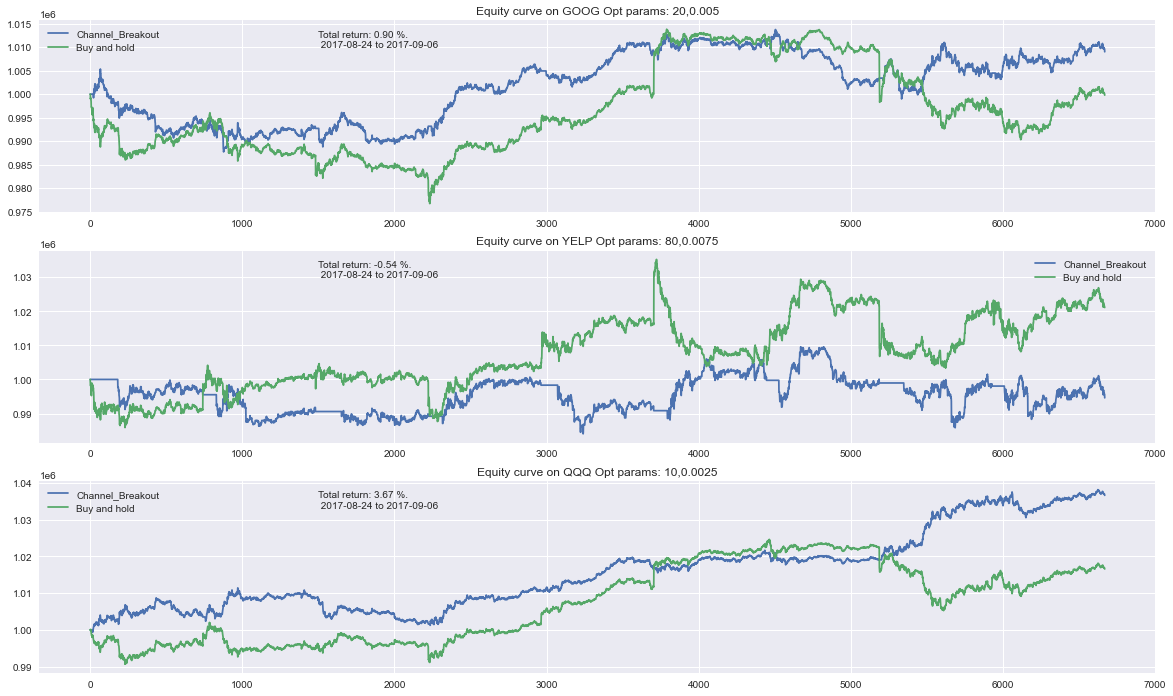

In [7]:

fig,axes=plt.subplots(3,1,figsize=(20,12))

for i,ticker in enumerate(ticker_list):
    
    tot_equity_df=cb_equity_dict[ticker]

    plot_equity_curve(tot_equity_df,ticker,cb_params_dict[ticker],signal_name='Channel_Breakout',ax=axes[i])




